In [1]:
%env WORKDIR=/tmp/vault
%env VAULT_K8S_NAMESPACE=vault
%env VAULT_HELM_RELEASE_NAME=vault
%env VAULT_SERVICE_NAME=vault-internal 
%env K8S_CLUSTER_NAME=cluster.local 

env: WORKDIR=/tmp/vault
env: VAULT_K8S_NAMESPACE=vault
env: VAULT_HELM_RELEASE_NAME=vault
env: VAULT_SERVICE_NAME=vault-internal
env: K8S_CLUSTER_NAME=cluster.local


In [2]:
%%bash
cat ${WORKDIR}/cluster-keys.json | jq -r ".root_token"

hvs.t4iAw7BbQv5g5NEpK5nRuZGB


In [3]:
%env VAULT_ADDR=https://127.0.0.1:8200
%env VAULT_TOKEN=hvs.t4iAw7BbQv5g5NEpK5nRuZGB
%env VAULT_CACERT=/tmp/vault/vault.ca

env: VAULT_ADDR=https://127.0.0.1:8200
env: VAULT_TOKEN=hvs.t4iAw7BbQv5g5NEpK5nRuZGB
env: VAULT_CACERT=/tmp/vault/vault.ca


### Instalando el VSO usando helm

In [7]:
%%bash
helm search repo hashicorp/vault-secrets-operator --devel
helm install --namespace $VAULT_K8S_NAMESPACE vault-secrets-operator hashicorp/vault-secrets-operator


NAME                            	CHART VERSION	APP VERSION	DESCRIPTION                          
hashicorp/vault-secrets-operator	0.3.4        	0.3.4      	Official Vault Secrets Operator Chart
NAME: vault-secrets-operator
LAST DEPLOYED: Fri Nov  3 14:19:07 2023
NAMESPACE: vault
STATUS: deployed
REVISION: 1


In [8]:
%%bash
## VaultConnection Custom Resource
cat > vso_crd.yaml <<EOF
---
apiVersion: secrets.hashicorp.com/v1beta1
kind: VaultConnection
metadata:
  namespace: vault
  name: example
spec:
  address: https://vault.vault.svc.cluster.local:8200
  skipTLSVerify: true

EOF
kubectl apply -f vso_crd.yaml
echo '---'
kubectl describe VaultConnection example -n vault


vaultconnection.secrets.hashicorp.com/example created
---
Name:         example
Namespace:    vault
Labels:       <none>
Annotations:  <none>
API Version:  secrets.hashicorp.com/v1beta1
Kind:         VaultConnection
Metadata:
  Creation Timestamp:  2023-11-03T13:19:45Z
  Finalizers:
    vaultconnection.secrets.hashicorp.com/finalizer
  Generation:        1
  Resource Version:  1090
  UID:               5a588405-8280-44ed-84a9-d6dcb4899c34
Spec:
  Address:          https://vault.vault.svc.cluster.local:8200
  Skip TLS Verify:  true
Status:
  Valid:  true
Events:
  Type    Reason    Age   From             Message
  ----    ------    ----  ----             -------
  Normal  Accepted  0s    VaultConnection  VaultConnection accepted


In [35]:
%%bash
cat > vaultauth_crd.yaml <<EOF
---
apiVersion: secrets.hashicorp.com/v1beta1
kind: VaultAuth
metadata:
  namespace: vault
  name: example
spec:
  vaultConnectionRef: example
  method: kubernetes
  mount: kubernetes
  namespace: "test"
  kubernetes:
    role: role
    serviceAccount: default
EOF
kubectl apply -f vaultauth_crd.yaml
echo '---'
kubectl describe VaultAuth example -n vault

vaultauth.secrets.hashicorp.com/example configured
---
Name:         example
Namespace:    vault
Labels:       <none>
Annotations:  <none>
API Version:  secrets.hashicorp.com/v1beta1
Kind:         VaultAuth
Metadata:
  Creation Timestamp:  2023-11-03T13:20:51Z
  Finalizers:
    vaultauth.secrets.hashicorp.com/finalizer
  Generation:        4
  Resource Version:  7434
  UID:               bd0ea454-5cae-4225-bc61-6a62a4c6bf27
Spec:
  Kubernetes:
    Role:                      role
    Service Account:           default
    Token Expiration Seconds:  600
  Method:                      kubernetes
  Mount:                       kubernetes
  Namespace:                   test
  Vault Connection Ref:        example
Status:
  Error:  
  Valid:  true
Events:
  Type    Reason    Age                From       Message
  ----    ------    ----               ----       -------
  Normal  Accepted  50m (x3 over 78m)  VaultAuth  Successfully handled VaultAuth resource request


In [10]:
%%bash
# Add system:auth-delegator to default service account
kubectl create -f - <<EOF
apiVersion: rbac.authorization.k8s.io/v1
kind: ClusterRoleBinding
metadata:
  name: role-tokenreview-binding
roleRef:
  apiGroup: rbac.authorization.k8s.io
  kind: ClusterRole
  name: system:auth-delegator
subjects:
  - kind: ServiceAccount
    name: default
    namespace: vault
EOF

clusterrolebinding.rbac.authorization.k8s.io/role-tokenreview-binding created


## CRD Static Secret

In [49]:
%%bash
## Support KVv1 and KVv2
cat > static_secret.yaml <<EOF
---
apiVersion: secrets.hashicorp.com/v1beta1
kind: VaultStaticSecret
metadata:
  namespace: vault
  name: example
spec:
  vaultAuthRef: example
  namespace: test #Adding Vault namespace
  mount: kvv2
  type: kv-v2
  path: webapp/config
  refreshAfter: 60s
  destination:
    create: true
    name: static-secret1
EOF
kubectl apply -f static_secret.yaml
echo '---'
kubectl describe VaultStaticSecret example -n vault
echo '---'
sleep 5
kubectl get secret static-secret1 -n vault -o yaml


vaultstaticsecret.secrets.hashicorp.com/example created
---
Name:         example
Namespace:    vault
Labels:       <none>
Annotations:  <none>
API Version:  secrets.hashicorp.com/v1beta1
Kind:         VaultStaticSecret
Metadata:
  Creation Timestamp:  2023-11-03T15:08:53Z
  Generation:          1
  Resource Version:    9795
  UID:                 0ac1d408-3beb-497d-985f-043f55e63f3a
Spec:
  Destination:
    Create:          true
    Name:            static-secret1
  Hmac Secret Data:  true
  Mount:             kvv2
  Namespace:         test
  Path:              webapp/config
  Refresh After:     60s
  Type:              kv-v2
  Vault Auth Ref:    example
Status:
  Secret MAC:  JpNdiBwGhIwNKfYOZAcW3bpviEwa8DxpqOb80JhTqS0=
Events:
  Type    Reason        Age   From               Message
  ----    ------        ----  ----               -------
  Normal  SecretSynced  0s    VaultStaticSecret  Secret synced
---
apiVersion: v1
data:
  _raw: eyJkYXRhIjp7InBhc3N3b3JkIjoic3RhdGljLXBhc3N3b3JkIi

In [50]:
%%bash

kubectl create ns nested

# Including other service account in the mix
kubectl delete ClusterRoleBinding role-tokenreview-binding

kubectl create -f - <<EOF
apiVersion: rbac.authorization.k8s.io/v1
kind: ClusterRoleBinding
metadata:
  name: role-tokenreview-binding
roleRef:
  apiGroup: rbac.authorization.k8s.io
  kind: ClusterRole
  name: system:auth-delegator
subjects:
  - kind: ServiceAccount
    name: default
    namespace: vault
  - kind: ServiceAccount
    name: default
    namespace: nested
EOF

# Adding a VaultAuth in another domain
cat > vaultauth_crd.yaml <<EOF
---
apiVersion: secrets.hashicorp.com/v1beta1
kind: VaultAuth
metadata:
  namespace: nested
  name: example
spec:
  vaultConnectionRef: vault/example
  method: kubernetes
  mount: kubernetes
  namespace: "test/nested"
  kubernetes:
    role: role
    serviceAccount: default
EOF
kubectl apply -f vaultauth_crd.yaml
echo '---'
kubectl describe VaultAuth example -n vault

namespace "nested" deleted
namespace/nested created
clusterrolebinding.rbac.authorization.k8s.io "role-tokenreview-binding" deleted
clusterrolebinding.rbac.authorization.k8s.io/role-tokenreview-binding created
vaultauth.secrets.hashicorp.com/example created
---
Name:         example
Namespace:    vault
Labels:       <none>
Annotations:  <none>
API Version:  secrets.hashicorp.com/v1beta1
Kind:         VaultAuth
Metadata:
  Creation Timestamp:  2023-11-03T13:20:51Z
  Finalizers:
    vaultauth.secrets.hashicorp.com/finalizer
  Generation:        4
  Resource Version:  7434
  UID:               bd0ea454-5cae-4225-bc61-6a62a4c6bf27
Spec:
  Kubernetes:
    Role:                      role
    Service Account:           default
    Token Expiration Seconds:  600
  Method:                      kubernetes
  Mount:                       kubernetes
  Namespace:                   test
  Vault Connection Ref:        example
Status:
  Error:  
  Valid:  true
Events:
  Type    Reason    Age           

In [53]:
%%bash
## Support KVv1 and KVv2
cat > static_secret.yaml <<EOF
---
apiVersion: secrets.hashicorp.com/v1beta1
kind: VaultStaticSecret
metadata:
  namespace: nested
  name: example
spec:
  vaultAuthRef: example
  namespace: test/nested
  mount: kvv2
  type: kv-v2
  path: webapp/config
  refreshAfter: 60s
  destination:
    create: true
    name: static-secret1
EOF
kubectl apply -f static_secret.yaml
echo '---'
kubectl describe VaultStaticSecret example -n vault
echo '---'
sleep 5
kubectl get secret static-secret1 -n vault -o yaml


vaultstaticsecret.secrets.hashicorp.com/example created
---
Name:         example
Namespace:    vault
Labels:       <none>
Annotations:  <none>
API Version:  secrets.hashicorp.com/v1beta1
Kind:         VaultStaticSecret
Metadata:
  Creation Timestamp:  2023-11-03T15:08:53Z
  Generation:          1
  Resource Version:    9795
  UID:                 0ac1d408-3beb-497d-985f-043f55e63f3a
Spec:
  Destination:
    Create:          true
    Name:            static-secret1
  Hmac Secret Data:  true
  Mount:             kvv2
  Namespace:         test
  Path:              webapp/config
  Refresh After:     60s
  Type:              kv-v2
  Vault Auth Ref:    example
Status:
  Secret MAC:  JpNdiBwGhIwNKfYOZAcW3bpviEwa8DxpqOb80JhTqS0=
Events:
  Type    Reason        Age                  From               Message
  ----    ------        ----                 ----               -------
  Normal  SecretSynced  3m45s                VaultStaticSecret  Secret synced
  Normal  SecretSync    22s (x4 over 2

In [54]:
%%bash
cat > mypod.yaml <<EOF
apiVersion: v1
kind: Pod
metadata:
  name: mypod
  namespace: nested
spec:
  containers:
  - name: mypod
    image: nginx
    volumeMounts:
    - name: foo
      mountPath: "/etc/foo"
      readOnly: true
  volumes:
  - name: foo
    secret:
      secretName: static-secret1
      optional: true
EOF
kubectl apply -f mypod.yaml
sleep 10

# https://developer.hashicorp.com/vault/tutorials/kubernetes/vault-secrets-operator

pod/mypod created


In [55]:
%%bash 
kubectl exec mypod -n nested -- ls /etc/foo
echo ""
echo "------"
kubectl exec mypod -n nested -- cat /etc/foo/_raw

_raw
password
username

------
{"data":{"password":"other-password","username":"other-user"},"metadata":{"created_time":"2023-11-03T15:05:31.848287712Z","custom_metadata":null,"deletion_time":"","destroyed":false,"version":1}}

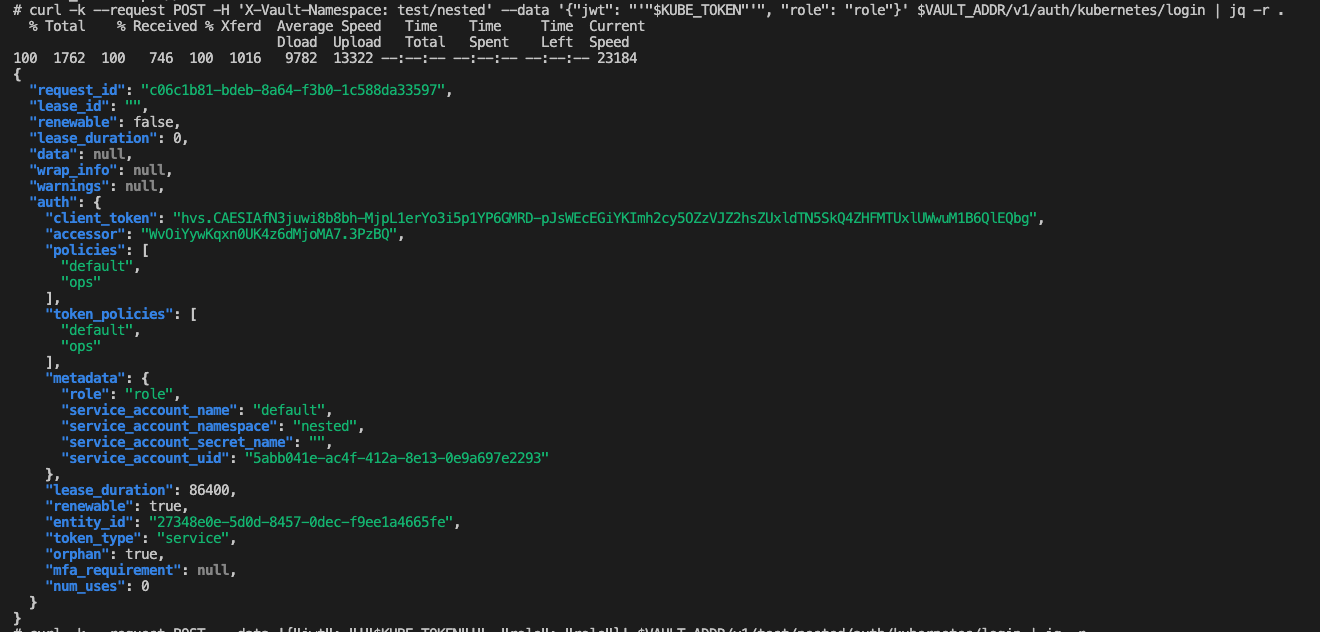